<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Longitudinal Prediction**

Can we use previous year's data and compoundingly predict suicide risk?

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

___________

### **Helper Functions**

In [3]:
def get_yearly_columns(base_cols, years):
    return [f"{col}{year}" for col in base_cols for year in years]

In [4]:
def get_encoded_columns(df, variables):
    cols = set()
    for var in variables:
        cs = df.filter(regex=fr"^{var}.+").columns.tolist()
        for c in cs:
            match = re.search(r"(.+)(\d{4})", c)
            if match:
                c_name, _ = match.groups()
                cols.add(c_name)
    return cols

___________

### **Data**

In [5]:
cohorts = range(2023, 2027)
years = range(2020, 2024)

In [6]:
# Read formatted linked persons
final23 = pd.read_csv("processed/final23.csv")
final24 = pd.read_csv("processed/final24.csv")
final25 = pd.read_csv("processed/final25.csv")
final26 = pd.read_csv("processed/final26.csv")
all_linked = pd.concat([final23, final24, final25, final26], ignore_index=True, axis=0)

final = {
    2023: final23,
    2024: final24,
    2025: final25,
    2026: final26,
}

In [7]:
# Read encoded linked persons
encoded23 = pd.read_csv("encoded/encoded23.csv")
encoded24 = pd.read_csv("encoded/encoded24.csv")
encoded25 = pd.read_csv("encoded/encoded25.csv")
encoded26 = pd.read_csv("encoded/encoded26.csv")

In [8]:
for year in years:
    final23[f"HasResponse{year}"] = final23[f"HasResponse{year}"].replace(-1, 0)
    encoded23[f"HasResponse{year}"] = encoded23[f"HasResponse{year}"].replace(-1, 0)

________

In [9]:
# Questions sorted by categorical, ordinal, and quantitative

ordinal_cols = {
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
}

quant_cols = {
    "INV.DBL.APSS.Total",
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Total",
}

cat_cols = {
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.White",
    "SBJ.LGL.Race.Multiple",
}

In [10]:
# All common questions across years

# Survey
survey = [
    "Unnamed: 0",
    "IDX.INT.Origin.Database",
    "IDX.INT.Origin.Record",
    "SSS.INT.SurveyYear",
    "IDX.INT.Row",
    "IDX.CHR.Linked.ID",
    "QCC.LGC.Linked.Attempted",
    "QCC.LGC.Linked",
    "QCC.LGC.Linked.No_issues",
    "QCC.CHR.Linked.Score.Base",
    "QCC.CHR.Linked.Score.Add",
    "QCC.CHR.Linked.Rows",
    "QCC.CHR.Linked.Dissimilarity",
]
   
# Adolescent Psychotic-like Symptoms 
psychotic = [
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.DBL.APSS.Total",
]
    
# Emotional Reactivity 
emotional = [
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
]
    
# PHQ4
phq4 = [
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.PHQ4.Total",
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    # "INV.FCT.PHQ4.Total",
]
    
# Suicidality
suicide = [
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
]
    
# Substance Use
substance = [
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
    
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
]
    
# Help Seeking
help = [
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    # "INV.CHR.HelpSeeking.Other",
]
    
# Identity
identity = [
    # "SBJ.CHR.Gender.Other",
    # "SBJ.CHR.Link.Streetname",
    # "SBJ.CHR.SexualOrientation.Other",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    # "SBJ.FCT.Link.BirthMonth",
    # "SBJ.FCT.Link.EyeColor",
    # "SBJ.FCT.Link.MiddleInitial",
    # "SBJ.FCT.Link.OlderSiblings",
    # "SBJ.FCT.Race",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    # "SBJ.INT.Link.KindergartenYearEst",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.Multiple",
    # "SBJ.LGL.Race.Other",
    "SBJ.LGL.Race.White",
]
    
# School
school = [
    "SSS.CHR.GradesSurveyed",
    "SSS.DBL.PercentOptOutsbyGrades",
    "SSS.DBL.PercentOptOutsbySchool",
    "SSS.INT.Cohort",
    "SSS.INT.District.Code",
    "SSS.INT.Eighth.Grade.Enrollment",
    "SSS.INT.Eleventh.Grade.Enrollment",
    "SSS.INT.Fifth.Grade.Enrollment",
    "SSS.INT.Grade",
    "SSS.INT.Ninth.Grade.Enrollment",
    "SSS.INT.School.Code",
    "SSS.INT.Seventh.Grade.Enrollment",
    "SSS.INT.Sixth.Grade.Enrollment",
    "SSS.INT.Tenth.Grade.Enrollment",
    "SSS.INT.Time_point",
    "SSS.INT.Twelfth.Grade.Enrollment",
]

all_qs = psychotic + help + suicide + school + identity + substance + phq4

In [11]:
psychotic_e = get_encoded_columns(encoded23, psychotic)
emotional_e = get_encoded_columns(encoded23, emotional)
phq4_e = get_encoded_columns(encoded23, phq4)
suicide_e = get_encoded_columns(encoded23, suicide)
substance_e = get_encoded_columns(encoded23, substance)
help_e = get_encoded_columns(encoded23, help)
identity_e = get_encoded_columns(encoded23, identity)

In [12]:
cats = {
    "regular": {
        "psychotic": psychotic,
        "emotional": emotional,
        "phq4": phq4,
        "suicide": suicide,
        "substance": substance,
        "help": help,
        "identity": identity,
    },
    "encoded": {
        "psychotic": psychotic_e,
        "emotional": emotional_e,
        "phq4": phq4_e,
        "suicide": suicide_e,
        "substance": substance_e,
        "help": help_e,
        "identity": identity_e,
    }
}

In [13]:
# `encoded` should be a string: "regular" or "encoded"
def get_cols(y_year, outcome, qs, encoded, prev):
    target_col= f"INV.INT.SI.{outcome}_1.0{y_year}" if encoded == "encoded" else f"INV.INT.SI.{outcome}{y_year}"
    
    feature_cols = []
    for q in qs:
        if q != "suicide":
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year])
        if prev:
            feature_cols += get_yearly_columns(cats[encoded][q], [y_year-1])
    
    return feature_cols, target_col

In [14]:
# Just previous year and curr year
def year_one_prediction_data(df, pred_year):
    df = df[df[f"HasResponse{pred_year}"] == 1]
    df = df[df[f"HasResponse{pred_year + 1}"] == 1]
    
    df = df.filter(regex=fr".*({pred_year}|{pred_year + 1})$", axis=1)
    
    df.rename(columns=lambda col: re.sub(fr"{pred_year}$", "0", col), inplace=True)
    df.rename(columns=lambda col: re.sub(fr"{pred_year + 1}$", "1", col), inplace=True)
    
    return df

In [15]:
# Training data for prev_imputation models
df_2022_2023 = year_one_prediction_data(encoded23, 2022)
df_2021_2022 = year_one_prediction_data(encoded23, 2021)
df_one_year  = pd.concat([df_2022_2023,df_2021_2022],ignore_index=True)

In [16]:
def curr_year_prediction_data(df, curr_year):
    df = df[df[f"HasResponse{curr_year}"] == 1]
    df = df.filter(regex=fr".*({curr_year})$", axis=1)
    df.rename(columns=lambda col: re.sub(fr"{curr_year}$", "1", col), inplace=True)
    return df

In [17]:
# Training data for curr_imputation models
df_2022 = curr_year_prediction_data(encoded23, 2022)
df_2023 = curr_year_prediction_data(encoded23, 2023)
df_curr  = pd.concat([df_2022, df_2023], ignore_index=True)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Rational**

What variables are actually important/have significance in our prediction model?

In [18]:
def plot_conditioned_vars(df, explore_qs, condition_q):
    filtered_df = df[df[condition_q] != -1]
    
    num_plots = len(explore_qs)
    num_cols = 4
    num_rows = math.ceil(num_plots / num_cols) 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows)) 
    axes = axes.flatten()

    for i, explore_q in enumerate(explore_qs):
        if explore_q == condition_q:
            continue
        
        filtered_df = filtered_df[filtered_df[explore_q] != -1]
        
        num_categories = len(set(filtered_df[explore_q]))
        if num_categories <= 3:
            count_df = filtered_df.groupby([condition_q, explore_q]).size().reset_index(name="Count")
            count_df["Proportion"] = count_df.groupby(condition_q)["Count"].transform(lambda x: x / x.sum())
            
            sns.barplot(
                x=condition_q, y="Proportion", hue=explore_q,
                data=count_df, palette=["lightcoral", "lightblue"], ax=axes[i]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(condition_q, fontsize=12)
            axes[i].set_ylabel("Proportion", fontsize=12)
            axes[i].set_ylim((0, 1))
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title=explore_q)
        else:
            sns.histplot(
                data=filtered_df, x=explore_q, hue=condition_q, bins=num_categories, kde=True, 
                stat="density", element="step", common_norm=False, ax=axes[i], palette=["lightcoral", "lightblue"]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(explore_q, fontsize=12)
            axes[i].set_ylabel("Frequency", fontsize=12)
            axes[i].legend(title=condition_q)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [19]:
"""
Uncomment the following code to distributions of variables conditioning on a specific suicidality question!
"""
# question = "Selfharm"
# category = suicide

# plot_conditioned_vars(final23, get_yearly_columns(category, [2023]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2022")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2021]), f"INV.INT.SI.{question}2022")

'\nUncomment the following code to distributions of variables conditioning on a specific suicidality question!\n'

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Fine-Tuning Final Models**

We are looking into the top models for each suicidality question.

In [20]:
all_mods = ["XGBoost", "RandomForest", "LDA", "LightGBM", "CatBoost", "NeuralNet", "SupportVector", "Logistic"]

In [35]:
# top models:
attempt_mods = ["RandomForest", "LightGBM", "NeuralNet", "SupportVector", "Logistic"]
how_mods = ["RandomForest", "XGBoost", "LightGBM", "NeuralNet", "Logistic"]
thoughts_mods = ["RandomForest", "Logistic"]
selfharm_mods = ["RandomForest", "LightGBM", "NeuralNet", "Logistic"]

outcome_models = {
    "Attempt": attempt_mods,
    "How": how_mods,
    "Thoughts": thoughts_mods,
    "Selfharm": selfharm_mods,
}

_______

### **Dependencies**

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve, average_precision_score, auc
from sklearn.preprocessing import PolynomialFeatures

# models tested
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [23]:
models = {
    "Logistic": (
        LogisticRegression(random_state=42), 
        {
            'C': np.logspace(-4,4,20),
            "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
            "solver": ['liblinear', 'lbfgs', 'newton-cg', ], 
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric='auc'),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42), 
        {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(), 
        {'solver': ['svd', 'lsqr', 'eigen']}
    ),
    "LightGBM": (
        LGBMClassifier(), 
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "CatBoost": (
        CatBoostClassifier(verbose=0), 
        {'iterations': [50, 100], 'depth': [4, 6]}
    ),
    "NeuralNet": (
        MLPClassifier(max_iter=500), 
        {'hidden_layer_sizes': [(50,), (100,)], 'max_iter': [300, 500]}
    ),
    "SupportVector": (
        SVC(probability=True), 
        {'C': [0.1, 1, 10]}
    )
}

In [51]:
models_ft = {
    # 'Logistic': (
    #     LogisticRegression(random_state=42), 
    #     {
    #         'C': np.logspace(-4, 4, 10), 
    #         'penalty': ['l1', 'l2', 'elasticnet'],
    #         'solver': ['liblinear', 'saga'], 
    #     }
    # ),
    "Logistic": (
        LogisticRegression(random_state=42), 
        {
            'C': np.logspace(-4,4,20),
            "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
            "solver": ['liblinear', 'lbfgs', 'newton-cg', ], 
        }
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42), 
        {
            'n_estimators': [50, 100, 200],  # Reasonable tree counts
            'max_depth': [10, 20, None],  # Limiting the depth for generalization
            'min_samples_split': [2, 10],  # Balance between complexity and efficiency
        }
    ),
    # "RandomForest": (
    #     RandomForestClassifier(random_state=42), 
    #     {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    # ),
    # "NeuralNet": (
    #     MLPClassifier(max_iter=500), 
    #     {
    #         'hidden_layer_sizes': [(50,), (100,)],  # Two simple architectures
    #         'activation': ['relu'],  # ReLU is almost always superior for deep learning
    #         'solver': ['adam'],  # Adam is the best general optimizer (removes 'sgd' for efficiency)
    #         'learning_rate_init': [0.001, 0.01],  # Important for stable learning
    #     }
    # ),
    "NeuralNet": (
        MLPClassifier(max_iter=500), 
        {'hidden_layer_sizes': [(50,), (100,)], 'max_iter': [300, 500]}
    ),
    "SupportVector": (
        SVC(probability=True), 
        {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    ),
    # "SupportVector": (
    #     SVC(probability=True), 
    #     {'C': [0.1, 1, 10]}
    # ),
    "LightGBM": (
        LGBMClassifier(), 
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'num_leaves': [20, 31]}
    ),
    # "LightGBM": (
    #     LGBMClassifier(), 
    #     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    # ),
    "XGBoost": (
        XGBClassifier(eval_metric='auc'),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
    ),
    # "XGBoost": (
    #     XGBClassifier(eval_metric='auc'),
    #     {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    # ),
}

In [52]:
def train_models(df, outcome, pred_year, qs, encoded, model_params, prev, interactions=False):
    print(f"Fine-tuning models for {outcome}")
    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    
    # Filter out people who did not take the survey
    df = df[df[f"HasResponse{pred_year}"] == 1]
    if prev:
        df = df[df[f"HasResponse{pred_year-1}"] == 1]

    X, y = df[feature_cols], df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Get interaction terms
    if interactions:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_train_array = poly.fit_transform(X_train)
        X_test_array = poly.transform(X_test)

        X_train = pd.DataFrame(X_train_array, columns=poly.get_feature_names_out(feature_cols))
        X_test = pd.DataFrame(X_test_array, columns=poly.get_feature_names_out(feature_cols))
    
    X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)
    y_train, y_test = pd.Series(y_train), pd.Series(y_test)
    final_probs = X_test.copy() 
    final_probs[outcome] = y_test.values
    
    trained_models = {}

    # Tune models
    outcome_results = []
    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    ax_roc, ax_pr = axes
    for mod_name in outcome_models[outcome]:
        print(f"Tuning {mod_name} for {outcome}!")
                
        mod, param_grid = model_params[mod_name]
        grid_search = GridSearchCV(mod, param_grid, cv=5, scoring='recall', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Classification
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["no", "yes"], output_dict=True)
        
        # PR Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_score = auc(recall, precision)
        ax_pr.plot(recall, precision, marker='.', label=f'{mod_name}: {pr_score:.2f}')
        
        # Plot ROC Curve
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        final_probs[f"probs{mod_name}"] = y_pred_proba
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        ax_roc.plot(fpr, tpr, label=f"{mod_name} (AUC = {auc_score:.3f})")
        
        outcome_results.append({
            "Model": mod_name,
            "Best Params": grid_search.best_params_,
            "Accuracy": accuracy,
            "ROC AUC": auc_score,
            "Precision": report["yes"]["precision"],
            "Recall": report["yes"]["recall"],
            "F1": report["yes"]["f1-score"],
            "PR Score": pr_score,
        })
        
        trained_models[mod_name] = best_model

        print(f"{mod_name} - Best Params: {grid_search.best_params_}, PR: {pr_score:.3f}")
    
    # ROC subplot
    ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"ROC Curves for {outcome} Models")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # PR subplot
    ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_ylim(0, 1)
    ax_pr.set_title(f'Precision-Recall Curves for {outcome}')
    ax_pr.legend()
    ax_pr.grid(True)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(outcome_results), final_probs, trained_models

Fine-tuning models for Attempt
Tuning RandomForest for Attempt!
RandomForest - Best Params: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}, PR: 0.532
Tuning LightGBM for Attempt!
[LightGBM] [Info] Number of positive: 130, number of negative: 4148
[LightGBM] [Info] Number of positive: 130, number of negative: 4148
[LightGBM] [Info] Number of positive: 130, number of negative: 4148
[LightGBM] [Info] Number of positive: 131, number of negative: 4148
[LightGBM] [Info] Number of positive: 131, number of negative: 4148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNet - Best Params: {'hidden_layer_sizes': (100,), 'max_iter': 500}, PR: 0.330
Tuning SupportVector for Attempt!
SupportVector - Best Params: {'C': 10, 'kernel': 'rbf'}, PR: 0.468
Tuning Logistic for Attempt!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'liblinear'}, PR: 0.409


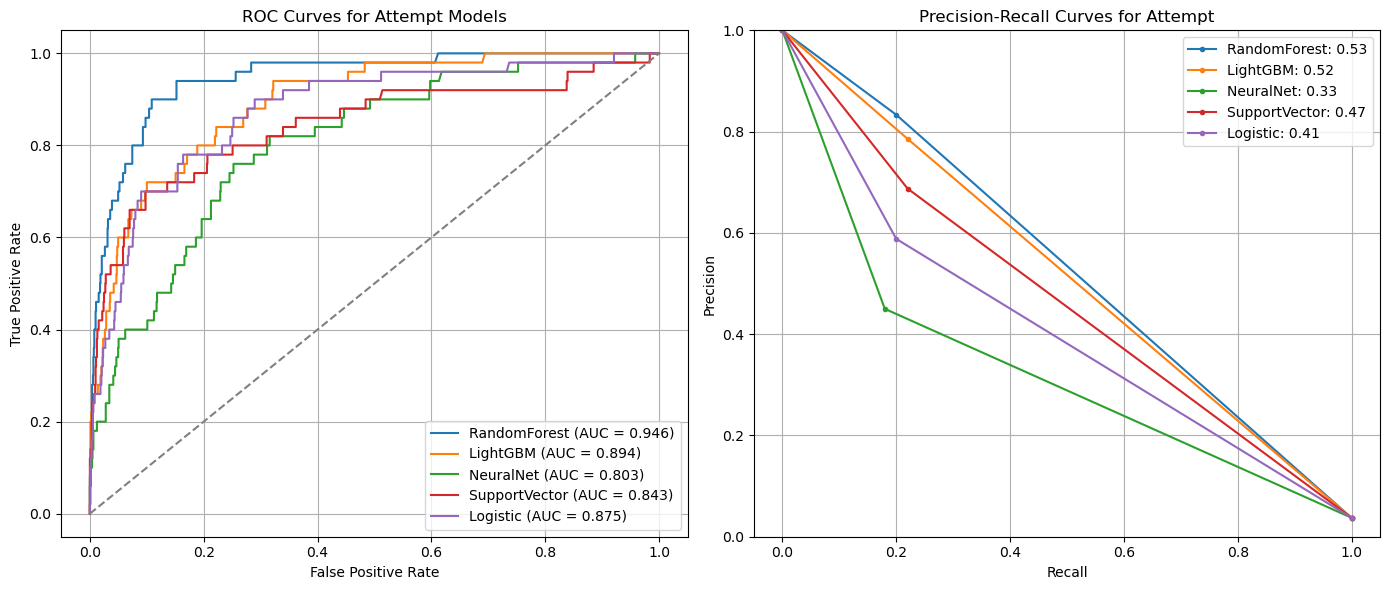

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1,PR Score
0,RandomForest,"{'max_depth': 20, 'min_samples_split': 10, 'n_...",0.968610,0.945939,0.833333,0.20,0.322581,0.531614
1,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.968610,0.893540,0.785714,0.22,0.343750,0.517431
2,NeuralNet,"{'hidden_layer_sizes': (100,), 'max_iter': 500}",0.961136,0.802981,0.450000,0.18,0.257143,0.330321
3,SupportVector,"{'C': 10, 'kernel': 'rbf'}",0.967115,0.843401,0.687500,0.22,0.333333,0.468324
4,Logistic,"{'C': 3792.690190732246, 'penalty': 'l2', 'sol...",0.964873,0.874984,0.588235,0.20,0.298507,0.409065


,Model,Accuracy,ROC AUC,Precision,Recall,F1,PR AUC
0,RandomForest,0.987374,0.951565,1.000000,0.230769,0.375000,0.621698
1,LightGBM,0.994949,0.944060,0.909091,0.769231,0.833333,0.841055
2,NeuralNet,0.993687,0.951960,0.785714,0.846154,0.814815,0.817197
3,SupportVector,0.989899,0.963612,0.777778,0.538462,0.636364,0.661908
4,Logistic,0.989899,0.904562,1.000000,0.384615,0.555556,0.697358


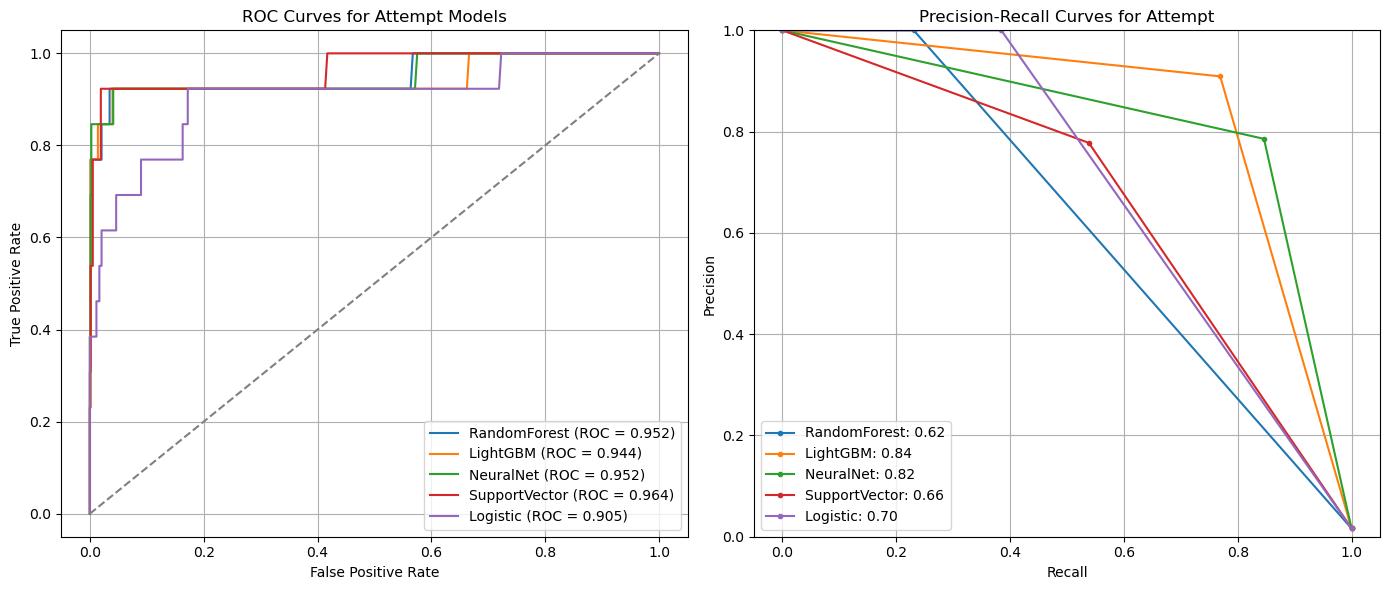

In [53]:
"""
Uncomment the following code to fine-tune a particular model on the data!
"""

df = df_curr
train_data, test_data = train_test_split(df, test_size=0.2, random_state=24)
outcome = "Attempt"
pred_year = 1
qs = [
    "psychotic", 
    "phq4", 
    "suicide", 
    "substance", 
    "help", 
    "identity"
]
encoded = "encoded"
interactions = False
model_params = models_ft
prev = False

# Training and Validation
attempt_results, attempt_final_probs, trained_models = train_models(train_data, outcome, pred_year, qs, encoded, model_params, prev, interactions=interactions)
display(attempt_results)

# Testing the model
final_stats = []
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
ax_roc, ax_pr = axes
for mod_name, trained_mod in trained_models.items():
    feature_cols, target_col = get_cols(pred_year, outcome, qs, encoded, prev)
    X, y = df_2022_2023[feature_cols], df_2022_2023[target_col]
    y_pred = trained_mod.predict(X)
    
    # Classification
    accuracy = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, target_names=["no", "yes"], output_dict=True)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y, y_pred)
    pr_score = auc(recall, precision)
    ax_pr.plot(recall, precision, marker='.', label=f'{mod_name}: {pr_score:.2f}')
    
    # Probabilities
    y_pred_proba = trained_mod.predict_proba(X)[:, 1]
    roc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    ax_roc.plot(fpr, tpr, label=f"{mod_name} (ROC = {roc_score:.3f})")
    
    final_stats.append({
        "Model": mod_name,
        "Accuracy": accuracy,
        "ROC AUC": roc_score,
        "Precision": report["yes"]["precision"],
        "Recall": report["yes"]["recall"],
        "F1": report["yes"]["f1-score"],
        "PR AUC": pr_score,
    })
    
display(pd.DataFrame(final_stats))

# Finalizing the ROC subplot
ax_roc.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title(f"ROC Curves for {outcome} Models")
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# Finalizing the PR subplot
ax_pr.plot([0, 0], [1, 1], linestyle='--', color='gray')  # Reference line
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_ylim(0, 1)
ax_pr.set_title(f'Precision-Recall Curves for {outcome}')
ax_pr.legend()
ax_pr.grid(True)

# Show both subplots
plt.tight_layout()
plt.show()

### **Best Parameters**

**Predicting "Attempt"**
- Random Forest:
- LightGBM:
- Neural Net: 
- Support Vector:
- Logistic:

**Predicting "How"**
- Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
- XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
- LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
- Neural Net: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
- Logistic: {'C': 11.288378916846883, 'penalty': 'l2', 'solver': 'lbfgs'}

**Predicting "Thoughts"**
- Random Forest:
- Neural Net:
- Logistic:

**Predicting "Self Harm"**
- Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
- Neural Net: 
- Logistic:

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Compounding Model**

In [27]:
# Imputing suicidality responses (classification and probability)

# Predicting current year responses using current year responses to non-suicidality questions
curr_imputation = {
    "Attempt": ...,
    "How": ...,
    "Thoughts": ...,
    "Selfharm": ...,
}

# Predicting current year responses using current year responses to non-suicidality questions and previous year responses (including suicidality questions)
prev_imputation = {
    "Attempt": ...,
    "How": ...,
    "Thoughts": ...,
    "Selfharm": ...,
}

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>